In [12]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../../_data/Tavares2017.csv')
data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 2 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)
data_df['sbj'] += 1

data_df['Right Value - Left Value'] = data_df['item_value_1'] - data_df['item_value_0']

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])


min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

obs_test = np.asarray(data_df[['rt', 'choice']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

print(X_train.shape, X_test.shape)

(30464, 4) (30464, 4)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 87        
                                                                 
Total params: 380 (1.48 KB)
Trainable params: 380 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3000)

Epoch 1/3000
1/1 [==============================] - 1548s 1548s/step - loss: 163111.5000
Epoch 2/3000
1/1 [==============================] - 0s 246ms/step - loss: 162492.1875
Epoch 3/3000
1/1 [==============================] - 0s 210ms/step - loss: 162042.2188
Epoch 4/3000
1/1 [==============================] - 0s 214ms/step - loss: 161662.2188
Epoch 5/3000
1/1 [==============================] - 0s 203ms/step - loss: 161322.0625
Epoch 6/3000
1/1 [==============================] - 0s 253ms/step - loss: 161007.9688
Epoch 7/3000
1/1 [==============================] - 0s 219ms/step - loss: 160712.3438
Epoch 8/3000
1/1 [==============================] - 0s 227ms/step - loss: 160430.4062
Epoch 9/3000
1/1 [==============================] - 0s 202ms/step - loss: 160159.0312
Epoch 10/3000
1/1 [==============================] - 0s 202ms/step - loss: 159895.9531
Epoch 11/3000
1/1 [==============================] - 0s 227ms/step - loss: 159639.5469
Epoch 12/3000
1/1 [==============================

1/1 [==============================] - 1s 661ms/step - loss: 131829.9844
Epoch 189/3000
1/1 [==============================] - 1s 623ms/step - loss: 131724.1250
Epoch 190/3000
1/1 [==============================] - 1s 736ms/step - loss: 131618.5781
Epoch 191/3000
1/1 [==============================] - 1s 660ms/step - loss: 131513.4062
Epoch 192/3000
1/1 [==============================] - 1s 615ms/step - loss: 131408.5156
Epoch 193/3000
1/1 [==============================] - 1s 620ms/step - loss: 131303.9688
Epoch 194/3000
1/1 [==============================] - 1s 597ms/step - loss: 131199.7500
Epoch 195/3000
1/1 [==============================] - 1s 621ms/step - loss: 131095.8438
Epoch 196/3000
1/1 [==============================] - 1s 600ms/step - loss: 130992.2969
Epoch 197/3000
1/1 [==============================] - 1s 605ms/step - loss: 130889.0469
Epoch 198/3000
1/1 [==============================] - 1s 626ms/step - loss: 130786.1016
Epoch 199/3000
1/1 [===========================

1/1 [==============================] - 1s 915ms/step - loss: 114125.2891
Epoch 375/3000
1/1 [==============================] - 1s 803ms/step - loss: 114035.1719
Epoch 376/3000
1/1 [==============================] - 1s 936ms/step - loss: 113945.2344
Epoch 377/3000
1/1 [==============================] - 1s 1s/step - loss: 113855.4297
Epoch 378/3000
1/1 [==============================] - 1s 871ms/step - loss: 113765.8047
Epoch 379/3000
1/1 [==============================] - 1s 636ms/step - loss: 113676.3281
Epoch 380/3000
1/1 [==============================] - 1s 736ms/step - loss: 113587.0156
Epoch 381/3000
1/1 [==============================] - 1s 735ms/step - loss: 113497.8828
Epoch 382/3000
1/1 [==============================] - 1s 692ms/step - loss: 113408.9297
Epoch 383/3000
1/1 [==============================] - 1s 696ms/step - loss: 113320.1562
Epoch 384/3000
1/1 [==============================] - 1s 572ms/step - loss: 113231.5625
Epoch 385/3000
1/1 [==============================

1/1 [==============================] - 1s 654ms/step - loss: 100448.4062
Epoch 561/3000
1/1 [==============================] - 1s 645ms/step - loss: 100387.8750
Epoch 562/3000
1/1 [==============================] - 1s 560ms/step - loss: 100327.2578
Epoch 563/3000
1/1 [==============================] - 1s 593ms/step - loss: 100266.9297
Epoch 564/3000
1/1 [==============================] - 1s 608ms/step - loss: 100206.5391
Epoch 565/3000
1/1 [==============================] - 1s 610ms/step - loss: 100146.4219
Epoch 566/3000
1/1 [==============================] - 1s 618ms/step - loss: 100086.2422
Epoch 567/3000
1/1 [==============================] - 1s 564ms/step - loss: 100026.3438
Epoch 568/3000
1/1 [==============================] - 1s 559ms/step - loss: 99966.3828
Epoch 569/3000
1/1 [==============================] - 1s 588ms/step - loss: 99906.7031
Epoch 570/3000
1/1 [==============================] - 1s 606ms/step - loss: 99846.9531
Epoch 571/3000
1/1 [==============================

1/1 [==============================] - 1s 661ms/step - loss: 90730.8750
Epoch 749/3000
1/1 [==============================] - 1s 631ms/step - loss: 90687.2188
Epoch 750/3000
1/1 [==============================] - 1s 660ms/step - loss: 90643.7656
Epoch 751/3000
1/1 [==============================] - 1s 677ms/step - loss: 90600.2656
Epoch 752/3000
1/1 [==============================] - 1s 649ms/step - loss: 90556.9688
Epoch 753/3000
1/1 [==============================] - 1s 620ms/step - loss: 90513.6172
Epoch 754/3000
1/1 [==============================] - 1s 598ms/step - loss: 90470.4844
Epoch 755/3000
1/1 [==============================] - 1s 618ms/step - loss: 90427.2891
Epoch 756/3000
1/1 [==============================] - 1s 675ms/step - loss: 90384.3125
Epoch 757/3000
1/1 [==============================] - 1s 689ms/step - loss: 90341.2656
Epoch 758/3000
1/1 [==============================] - 1s 644ms/step - loss: 90298.4375
Epoch 759/3000
1/1 [==============================] - 1s 5

1/1 [==============================] - 1s 632ms/step - loss: 83821.1562
Epoch 937/3000
1/1 [==============================] - 1s 602ms/step - loss: 83790.7031
Epoch 938/3000
1/1 [==============================] - 1s 655ms/step - loss: 83760.7266
Epoch 939/3000
1/1 [==============================] - 1s 982ms/step - loss: 83730.3203
Epoch 940/3000
1/1 [==============================] - 1s 598ms/step - loss: 83700.4766
Epoch 941/3000
1/1 [==============================] - 1s 641ms/step - loss: 83670.1719
Epoch 942/3000
1/1 [==============================] - 1s 671ms/step - loss: 83640.4141
Epoch 943/3000
1/1 [==============================] - 1s 639ms/step - loss: 83610.3359
Epoch 944/3000
1/1 [==============================] - 1s 656ms/step - loss: 83580.7031
Epoch 945/3000
1/1 [==============================] - 1s 646ms/step - loss: 83550.8594
Epoch 946/3000
1/1 [==============================] - 1s 594ms/step - loss: 83521.2734
Epoch 947/3000
1/1 [==============================] - 1s 6

Epoch 1030/3000
1/1 [==============================] - 1s 707ms/step - loss: 81247.1953
Epoch 1031/3000
1/1 [==============================] - 1s 831ms/step - loss: 81222.3516
Epoch 1032/3000
1/1 [==============================] - 1s 637ms/step - loss: 81197.5781
Epoch 1033/3000
1/1 [==============================] - 1s 610ms/step - loss: 81173.0469
Epoch 1034/3000
1/1 [==============================] - 1s 802ms/step - loss: 81148.8047
Epoch 1035/3000
1/1 [==============================] - 1s 623ms/step - loss: 81124.7266
Epoch 1036/3000
1/1 [==============================] - 1s 621ms/step - loss: 81101.0938
Epoch 1037/3000
1/1 [==============================] - 1s 649ms/step - loss: 81076.5938
Epoch 1038/3000
1/1 [==============================] - 1s 609ms/step - loss: 81052.3594
Epoch 1039/3000
1/1 [==============================] - 1s 584ms/step - loss: 81027.2422
Epoch 1040/3000
1/1 [==============================] - 1s 625ms/step - loss: 81002.9375
Epoch 1041/3000
1/1 [===========

1/1 [==============================] - 1s 657ms/step - loss: 79199.6953
Epoch 1124/3000
1/1 [==============================] - 1s 632ms/step - loss: 79180.3438
Epoch 1125/3000
1/1 [==============================] - 1s 615ms/step - loss: 79161.4297
Epoch 1126/3000
1/1 [==============================] - 1s 686ms/step - loss: 79142.7734
Epoch 1127/3000
1/1 [==============================] - 1s 689ms/step - loss: 79124.4219
Epoch 1128/3000
1/1 [==============================] - 1s 730ms/step - loss: 79106.3516
Epoch 1129/3000
1/1 [==============================] - 1s 679ms/step - loss: 79087.8906
Epoch 1130/3000
1/1 [==============================] - 1s 671ms/step - loss: 79069.2188
Epoch 1131/3000
1/1 [==============================] - 1s 866ms/step - loss: 79049.7266
Epoch 1132/3000
1/1 [==============================] - 1s 601ms/step - loss: 79030.6562
Epoch 1133/3000
1/1 [==============================] - 1s 654ms/step - loss: 79011.6719
Epoch 1134/3000
1/1 [===========================

1/1 [==============================] - 0s 457ms/step - loss: 76629.3750
Epoch 1310/3000
1/1 [==============================] - 0s 477ms/step - loss: 76619.8047
Epoch 1311/3000
1/1 [==============================] - 0s 484ms/step - loss: 76610.1406
Epoch 1312/3000
1/1 [==============================] - 0s 474ms/step - loss: 76601.2344
Epoch 1313/3000
1/1 [==============================] - 0s 474ms/step - loss: 76592.5391
Epoch 1314/3000
1/1 [==============================] - 0s 449ms/step - loss: 76583.7266
Epoch 1315/3000
1/1 [==============================] - 0s 404ms/step - loss: 76575.3750
Epoch 1316/3000
1/1 [==============================] - 0s 437ms/step - loss: 76566.2656
Epoch 1317/3000
1/1 [==============================] - 0s 461ms/step - loss: 76556.5078
Epoch 1318/3000
1/1 [==============================] - 0s 424ms/step - loss: 76546.5781
Epoch 1319/3000
1/1 [==============================] - 0s 456ms/step - loss: 76537.3203
Epoch 1320/3000
1/1 [===========================

1/1 [==============================] - 1s 643ms/step - loss: 75420.6875
Epoch 1496/3000
1/1 [==============================] - 1s 645ms/step - loss: 75405.8281
Epoch 1497/3000
1/1 [==============================] - 1s 672ms/step - loss: 75401.3828
Epoch 1498/3000
1/1 [==============================] - 1s 623ms/step - loss: 75399.3594
Epoch 1499/3000
1/1 [==============================] - 1s 610ms/step - loss: 75397.3828
Epoch 1500/3000
1/1 [==============================] - 1s 595ms/step - loss: 75397.3281
Epoch 1501/3000
1/1 [==============================] - 1s 637ms/step - loss: 75402.1797
Epoch 1502/3000
1/1 [==============================] - 1s 592ms/step - loss: 75391.5938
Epoch 1503/3000
1/1 [==============================] - 1s 563ms/step - loss: 75394.7656
Epoch 1504/3000
1/1 [==============================] - 1s 617ms/step - loss: 75388.1406
Epoch 1505/3000
1/1 [==============================] - 1s 547ms/step - loss: 75388.9688
Epoch 1506/3000
1/1 [===========================

1/1 [==============================] - 1s 612ms/step - loss: 74766.7266
Epoch 1682/3000
1/1 [==============================] - 1s 655ms/step - loss: 74763.4922
Epoch 1683/3000
1/1 [==============================] - 1s 603ms/step - loss: 74760.4219
Epoch 1684/3000
1/1 [==============================] - 1s 689ms/step - loss: 74759.8125
Epoch 1685/3000
1/1 [==============================] - 1s 647ms/step - loss: 74759.1406
Epoch 1686/3000
1/1 [==============================] - 1s 589ms/step - loss: 74758.9531
Epoch 1687/3000
1/1 [==============================] - 1s 585ms/step - loss: 74757.1875
Epoch 1688/3000
1/1 [==============================] - 1s 606ms/step - loss: 74756.4766
Epoch 1689/3000
1/1 [==============================] - 1s 606ms/step - loss: 74753.6562
Epoch 1690/3000
1/1 [==============================] - 1s 542ms/step - loss: 74751.4922
Epoch 1691/3000
1/1 [==============================] - 1s 642ms/step - loss: 74746.4219
Epoch 1692/3000
1/1 [===========================

1/1 [==============================] - 1s 662ms/step - loss: 74389.0156
Epoch 1868/3000
1/1 [==============================] - 1s 623ms/step - loss: 74386.2344
Epoch 1869/3000
1/1 [==============================] - 1s 618ms/step - loss: 74384.5625
Epoch 1870/3000
1/1 [==============================] - 1s 593ms/step - loss: 74377.8750
Epoch 1871/3000
1/1 [==============================] - 1s 572ms/step - loss: 74384.5312
Epoch 1872/3000
1/1 [==============================] - 1s 611ms/step - loss: 74380.5469
Epoch 1873/3000
1/1 [==============================] - 1s 575ms/step - loss: 74384.0938
Epoch 1874/3000
1/1 [==============================] - 1s 548ms/step - loss: 74376.2734
Epoch 1875/3000
1/1 [==============================] - 1s 619ms/step - loss: 74376.3047
Epoch 1876/3000
1/1 [==============================] - 1s 602ms/step - loss: 74376.7500
Epoch 1877/3000
1/1 [==============================] - 1s 572ms/step - loss: 74373.9219
Epoch 1878/3000
1/1 [===========================

1/1 [==============================] - 1s 644ms/step - loss: nan
Epoch 2057/3000
1/1 [==============================] - 1s 588ms/step - loss: nan
Epoch 2058/3000
1/1 [==============================] - 1s 791ms/step - loss: 74151.7266
Epoch 2059/3000
1/1 [==============================] - 1s 767ms/step - loss: 74154.2969
Epoch 2060/3000
1/1 [==============================] - 1s 541ms/step - loss: nan
Epoch 2061/3000
1/1 [==============================] - 1s 640ms/step - loss: nan
Epoch 2062/3000
1/1 [==============================] - 1s 637ms/step - loss: 74154.4375
Epoch 2063/3000
1/1 [==============================] - 1s 687ms/step - loss: nan
Epoch 2064/3000
1/1 [==============================] - 1s 662ms/step - loss: nan
Epoch 2065/3000
1/1 [==============================] - 1s 595ms/step - loss: 74158.5469
Epoch 2066/3000
1/1 [==============================] - 1s 588ms/step - loss: nan
Epoch 2067/3000
1/1 [==============================] - 1s 574ms/step - loss: nan
Epoch 2068/3000


1/1 [==============================] - 1s 639ms/step - loss: 73985.7266
Epoch 2249/3000
1/1 [==============================] - 1s 616ms/step - loss: 73983.7891
Epoch 2250/3000
1/1 [==============================] - 1s 661ms/step - loss: nan
Epoch 2251/3000
1/1 [==============================] - 1s 717ms/step - loss: nan
Epoch 2252/3000
1/1 [==============================] - 1s 630ms/step - loss: 74003.2578
Epoch 2253/3000
1/1 [==============================] - 1s 615ms/step - loss: 73996.5391
Epoch 2254/3000
1/1 [==============================] - 1s 645ms/step - loss: 73992.4844
Epoch 2255/3000
1/1 [==============================] - 1s 629ms/step - loss: nan
Epoch 2256/3000
1/1 [==============================] - 1s 652ms/step - loss: 73984.3828
Epoch 2257/3000
1/1 [==============================] - 1s 604ms/step - loss: 73979.1875
Epoch 2258/3000
1/1 [==============================] - 1s 638ms/step - loss: 73980.2344
Epoch 2259/3000
1/1 [==============================] - 1s 559ms/step 

1/1 [==============================] - 1s 612ms/step - loss: 73922.8906
Epoch 2343/3000
1/1 [==============================] - 1s 592ms/step - loss: 73920.0625
Epoch 2344/3000
1/1 [==============================] - 1s 687ms/step - loss: nan
Epoch 2345/3000
1/1 [==============================] - 1s 745ms/step - loss: 73915.3750
Epoch 2346/3000
1/1 [==============================] - 1s 593ms/step - loss: 73916.5156
Epoch 2347/3000
1/1 [==============================] - 1s 633ms/step - loss: 73915.2656
Epoch 2348/3000
1/1 [==============================] - 1s 639ms/step - loss: 73912.6172
Epoch 2349/3000
1/1 [==============================] - 1s 592ms/step - loss: 73911.9688
Epoch 2350/3000
1/1 [==============================] - 1s 580ms/step - loss: 73917.9688
Epoch 2351/3000
1/1 [==============================] - 1s 635ms/step - loss: 73918.8125
Epoch 2352/3000
1/1 [==============================] - 1s 706ms/step - loss: 73925.9844
Epoch 2353/3000
1/1 [==============================] - 

1/1 [==============================] - 1s 586ms/step - loss: 73865.9531
Epoch 2437/3000
1/1 [==============================] - 1s 625ms/step - loss: 73871.8828
Epoch 2438/3000
1/1 [==============================] - 0s 453ms/step - loss: 73869.7969
Epoch 2439/3000
1/1 [==============================] - 0s 380ms/step - loss: 73884.7656
Epoch 2440/3000
1/1 [==============================] - 1s 666ms/step - loss: nan
Epoch 2441/3000
1/1 [==============================] - 1s 622ms/step - loss: 73933.5156
Epoch 2442/3000
1/1 [==============================] - 1s 650ms/step - loss: nan
Epoch 2443/3000
1/1 [==============================] - 1s 638ms/step - loss: 73914.9375
Epoch 2444/3000
1/1 [==============================] - 1s 623ms/step - loss: 73889.4844
Epoch 2445/3000
1/1 [==============================] - 1s 668ms/step - loss: 73869.7969
Epoch 2446/3000
1/1 [==============================] - 1s 654ms/step - loss: 73867.2188
Epoch 2447/3000
1/1 [==============================] - 1s 621m

1/1 [==============================] - 1s 580ms/step - loss: 73852.1406
Epoch 2531/3000
1/1 [==============================] - 1s 593ms/step - loss: nan
Epoch 2532/3000
1/1 [==============================] - 1s 630ms/step - loss: 73862.1797
Epoch 2533/3000
1/1 [==============================] - 1s 603ms/step - loss: 73855.3750
Epoch 2534/3000
1/1 [==============================] - 1s 561ms/step - loss: 73854.0938
Epoch 2535/3000
1/1 [==============================] - 1s 610ms/step - loss: 73844.3750
Epoch 2536/3000
1/1 [==============================] - 1s 630ms/step - loss: 73846.1094
Epoch 2537/3000
1/1 [==============================] - 1s 615ms/step - loss: 73849.5156
Epoch 2538/3000
1/1 [==============================] - 1s 602ms/step - loss: 73851.8750
Epoch 2539/3000
1/1 [==============================] - 1s 648ms/step - loss: 73841.9688
Epoch 2540/3000
1/1 [==============================] - 1s 644ms/step - loss: 73842.4297
Epoch 2541/3000
1/1 [==============================] - 

1/1 [==============================] - 1s 642ms/step - loss: 73787.4297
Epoch 2717/3000
1/1 [==============================] - 1s 627ms/step - loss: nan
Epoch 2718/3000
1/1 [==============================] - 1s 604ms/step - loss: 73783.9141
Epoch 2719/3000
1/1 [==============================] - 1s 597ms/step - loss: 73780.6641
Epoch 2720/3000
1/1 [==============================] - 1s 636ms/step - loss: 73780.1875
Epoch 2721/3000
1/1 [==============================] - 1s 680ms/step - loss: 73776.1484
Epoch 2722/3000
1/1 [==============================] - 1s 594ms/step - loss: 73771.0938
Epoch 2723/3000
1/1 [==============================] - 1s 621ms/step - loss: 73775.3438
Epoch 2724/3000
1/1 [==============================] - 1s 584ms/step - loss: 73773.5781
Epoch 2725/3000
1/1 [==============================] - 1s 604ms/step - loss: 73777.8984
Epoch 2726/3000
1/1 [==============================] - 1s 567ms/step - loss: 73776.4062
Epoch 2727/3000
1/1 [==============================] - 

1/1 [==============================] - 0s 456ms/step - loss: 73738.2656
Epoch 2903/3000
1/1 [==============================] - 0s 489ms/step - loss: 73730.3281
Epoch 2904/3000
1/1 [==============================] - 0s 364ms/step - loss: 73730.1875
Epoch 2905/3000
1/1 [==============================] - 0s 447ms/step - loss: 73723.7656
Epoch 2906/3000
1/1 [==============================] - 0s 425ms/step - loss: 73726.1016
Epoch 2907/3000
1/1 [==============================] - 1s 524ms/step - loss: 73723.7266
Epoch 2908/3000
1/1 [==============================] - 0s 408ms/step - loss: 73734.4297
Epoch 2909/3000
1/1 [==============================] - 1s 547ms/step - loss: 73759.8516
Epoch 2910/3000
1/1 [==============================] - 0s 386ms/step - loss: 73758.5625
Epoch 2911/3000
1/1 [==============================] - 0s 470ms/step - loss: 73724.5078
Epoch 2912/3000
1/1 [==============================] - 0s 419ms/step - loss: 73711.3438
Epoch 2913/3000
1/1 [===========================

In [9]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

952/952 [==============================] - 1s 271us/step


In [10]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df.item_value_1[s] - ts_df.item_value_0[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

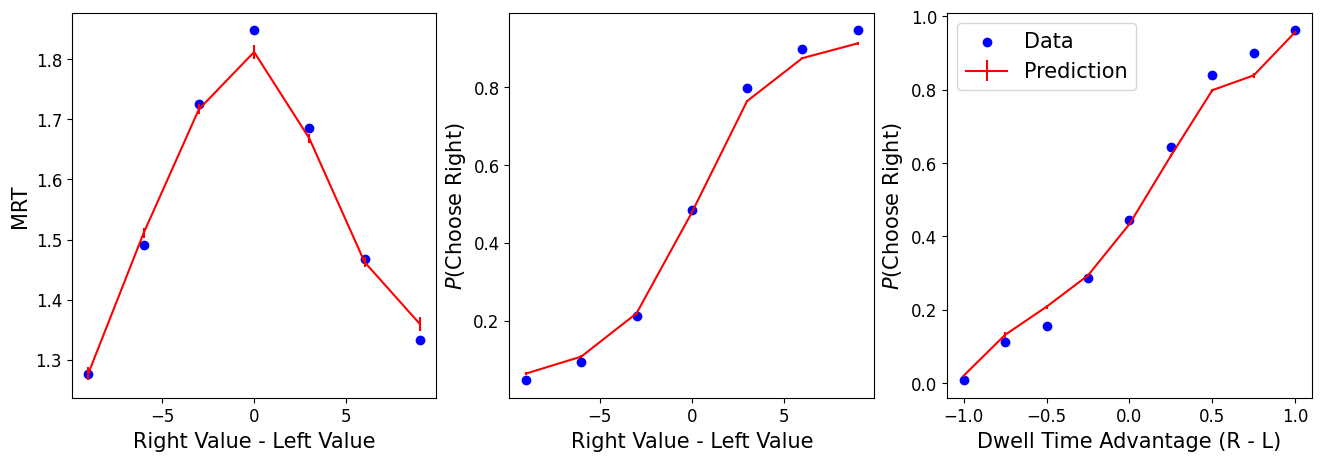

In [19]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
se = pred_bhv.groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(pred_bhv.groupby(by='value_diff')['value_diff'].mean(),
             pred_bhv.groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red')
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(132)
se = pred_bhv.groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv.groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(133)
se = pred_bhv.groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(),
             y=pred_bhv.groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), 
            c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/tv2017_complete_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

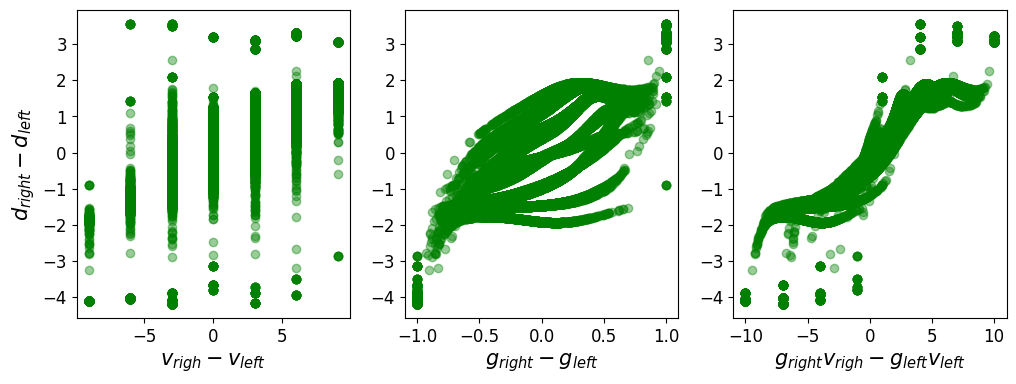

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 1] - X_test[:, 0], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');
plt.xlabel(r'$v_{righ} - v_{left}$ ');

plt.subplot(132)
plt.scatter(X_test[:, 3] - X_test[:, 2], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(133)
plt.scatter(X_test[:, 1]*X_test[:, 3] - X_test[:, 0]*X_test[:, 2], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/tv2017_complete_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');